# BrightnessContrast Example

This example demonstrates usage of `brightness_contrast` operator.

## Brighness and Contrast Adjustment

Brithness and contrast can be adjusted using three parameters:
`contrast` - makes the dark parts darker and bright parts brighter while keeping the gray (at half dynamic range of the input type) constant,

`brightness` - multiplies the intensities,

`brightness_shift` - shifts the pixel intensities.

The formula is given as:

$$
Out = brightness\_shift \cdot {Max}_{out} + brighness \cdot ({contrast\_center} + {contrast} \cdot ({in} - {contrast\_center}))
$$


where ${contrast\_center}$ denotes a value that is unaffected by contrast changes; by default, it's at half of the input's dynamic range (e.g. 128 for `uint8`) and ${Max}_{out}$ is the maximum positive value of the output type, for integer types, or 1 for floating point) - but it can also be specified as an argument for the operator.
The operator can be used to adjust contrast and brighness as well as to compute negative images (`brightness = -1`, `brighness_shift = 1`).


## Step-by-Step Guide
1. Let's start from importing necessary modules (and DALI itself).


In [1]:
from nvidia.dali import pipeline_def
import nvidia.dali.fn as fn
import nvidia.dali.types as types
import matplotlib.pyplot as plt

batch_size = 10
image_filename = "../data/images"

The `batch_size` is bigger than one to make it easier to switch images at the end of the example.

2. Next, let's implement the pipelines. We've presented 2 versions of a pipeline. The CPU one does all the processing (i.e. reading file, decoding it and brightness/contrast manipulation) on the CPU, while the other pipeline conducts these operations on the GPU.

In [2]:
@pipeline_def()
def bc_cpu_pipeline():
    files, labels = fn.readers.file(file_root=image_filename)
    images = fn.decoders.image(files)
    converted = fn.brightness_contrast(
        images, brightness_shift=0.3, contrast=0.4, contrast_center=100
    )
    return images, converted


@pipeline_def()
def bc_gpu_pipeline():
    files, labels = fn.readers.file(file_root=image_filename)
    images = fn.decoders.image(files, device="mixed")
    converted = fn.brightness_contrast(
        # increase contrast  # invert...
        images,
        contrast=1.5,
        brightness_shift=1,
        brightness=-1,
    )  # ...colors
    return images, converted

The function below is used to actually display result of manipulation. Since the pipelines we set up return 2 outputs: modified image and original image, the function aquires both of them from the output and displays them. Additional flag (`cpu`) is specified, to determine, whether the pipeline output comes from CPU or GPU. In the latter case, we have to tell the output, to return a CPU-accessible copy of the data.

In [3]:
def display(output, cpu=True):
    i = 2  # Tweak that to have various images from batch
    img1 = output[0].at(i) if cpu else output[0].as_cpu().at(i)
    img2 = output[1].at(i) if cpu else output[1].as_cpu().at(i)
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(img1)
    ax[1].imshow(img2);

3. Now let's just build the pipelines, run them and display the results. First the GPU one:

In [4]:
pipe_gpu = bc_gpu_pipeline(batch_size=batch_size, num_threads=1, device_id=0)
pipe_gpu.build()

In [5]:
gpu_output = pipe_gpu.run()

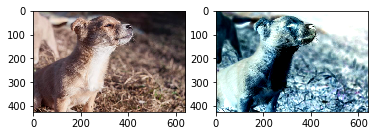

In [6]:
display(gpu_output, cpu=False)

4. And the CPU:

In [7]:
pipe_cpu = bc_cpu_pipeline(batch_size=batch_size, num_threads=1, device_id=0)
pipe_cpu.build()
cpu_output = pipe_cpu.run()

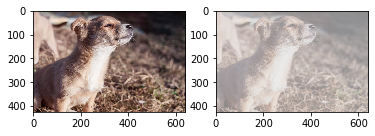

In [8]:
display(cpu_output)